<a href="https://colab.research.google.com/github/poeala/CoderHouse-Data-Science-2/blob/main/Colab_final_ciencia_datos_II_Andrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstracto: Motivación y Audiencia

---



Este trabajo continúa mi análisis exploratorio de datos (EDA, Exploratory Data Analysis) sobre Pokémon y formula el problema como una tarea de aprendizaje automático (ML, Machine Learning): predecir si un Pokémon es legendario (sí/no) a partir de sus atributos. Parto del dataset clásico de Kaggle (n=721; https://www.kaggle.com/datasets/abcsds/pokemon
) con estadísticas base (HP, Ataque, Defensa, Ataque Especial, Defensa Especial, Velocidad), tipos primario/secundario, generación y la etiqueta “legendario”, y lo enriquezco con PokeAPI incorporando altura, peso, experiencia base, cantidad de habilidades y cantidad de movimientos.

Guiada por las preguntas previas (si los legendarios exhiben valores medios mayores, qué combinaciones de tipos son más frecuentes/efectivas, y si mayor peso implica menor velocidad), realizo ingeniería de atributos:

type_combined (tipo_1–tipo_2),

índices ofensivos/defensivos (power_index = attack + sp_atk, bulk_index = defense + sp_def + hp, indice_ofensivo = attack × sp_atk),

métricas físico-funcionales (bmi_like = peso / altura², speed_weight_ratio = speed / (peso + ε), con ε un valor pequeño para evitar división por cero; p. ej., 1e-6).

Calculo la correlación de Pearson entre cada variable numérica y la etiqueta binaria ‘legendary’ (0/1): aparecen mayores asociaciones en índices agregados (p. ej., indice_ofensivo, total, power_index) y en stats clave (sp_atk, speed), además de base_exp_api (probable sesgo de diseño del juego). Algunos agregados muestran redundancia/colinealidad con stats base, lo que explica su alta correlación sin implicar fuga de información. Como la correlación es lineal, complemento con importancia por permutación (Permutation Importance) e información mutua (MI, Mutual Information) para captar relaciones no lineales y confirmar su contribución al desempeño.

Implemento un pipeline reproducible con imputación (mediana en numéricas, moda en categóricas), estandarización (media 0, desvío 1) y codificación one-hot (OHE, One-Hot Encoding) mediante ColumnTransformer, de modo que el preprocesamiento ocurre dentro del entrenamiento y evita fuga de información. Comparo tres modelos: Regresión Logística, Bosque Aleatorio (Random Forest) y SVC (Support Vector Classifier), usando validación cruzada estratificada (CV, Cross-Validation) k=5 y múltiples métricas: F1 (promedio armónico de precisión y sensibilidad), AUC-PR (Área Bajo la Curva Precisión–Recall) y AUC-ROC (Área Bajo la Curva Receiver Operating Characteristic).

Realizo búsqueda en grilla (GridSearchCV) para optimizar hiperparámetros en Random Forest y SVC, con función objetivo AUC-PR (adecuada por la baja prevalencia de la clase positiva). El mejor modelo es SVC con kernel RBF (Radial Basis Function), C=10 y gamma='scale'. Tras separar train/valid/test (60/20/20 a partir de un 80/20 inicial), selecciono el umbral (threshold) que maximiza F1 en validación (≈0.256) y evalúo en test: AUC-PR = 0.72 (vs. prevalencia ≈0.08), AUC-ROC = 0.98, Recall = 0.92, Precision = 0.71 y F1 = 0.80, con 12/13 verdaderos positivos y 5 falsos positivos.

Para interpretabilidad, aplico importancia por permutación en el espacio transformado; destacan speed (velocidad) y generation (generación), con aporte menor de peso y speed_weight_ratio. Varias variables derivadas muestran importancia cercana a cero por redundancia/colinealidad con estadísticas base. Completo el análisis con curvas PR y ROC, matriz de confusión y barrido de umbral para visualizar el trade-off (compromiso) entre recuperar legendarios y controlar falsos positivos.

Audiencia: equipos de game balance (equilibrio de juego) y analistas de datos interesados en qué atributos se asocian con la condición de legendario y en operar el modelo según distintas tolerancias a errores (ajustando el umbral). Alcance y limitaciones: el rendimiento refleja este dataset y su distribución (p. ej., la señal de generation sugiere sesgo de dominio); cambios en prevalencia, definiciones o generaciones futuras pueden requerir recalibración y reentrenamiento.

Preguntas:
* ¿Podemos clasificar legendary con atributos base y  datos enriquecidos de PokeAPI?

* ¿Qué variables más contribuyen a identificar legendary?

* ¿Qué trade-off F1/Precision/Recall conviene según el umbral?

# Resumen y Resultado

El modelo logra AUC-PR = 0.72 (Área Bajo la Curva Precisión–Recall), muy por encima de la prevalencia (~0.08, proporción de legendarios en los datos), y AUC-ROC = 0.98 (Área Bajo la Curva Receiver Operating Characteristic). Con umbral (threshold) 0.256 se obtiene Recall = 0.92 (sensibilidad: de los legendarios reales, cuántos detecto) y Precision = 0.71 (de los marcados como legendarios, cuántos lo son), con F1 = 0.80 (promedio armónico de precisión y sensibilidad). En números: 12/13 verdaderos positivos y 5 falsos positivos. La importancia por permutación (Permutation Importance; caída del desempeño al desordenar una variable) en el espacio transformado resalta speed (velocidad) y generation (generación), con aporte menor de peso y speed_weight_ratio (relación velocidad/peso). El umbral se eligió maximizando F1 para equilibrar precision y recall.

# Lectura de Archivos

In [1]:
!pip -q install -U scikit-learn==1.6.1 xgboost==3.0.5 shap==0.48.0 tqdm==4.67.1 kagglehub==0.3.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.5 MB/s eta 0:00:00


In [4]:
import os, time, glob, warnings, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import kagglehub
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#55038C'])

In [5]:


warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,5)

# Descarga y lectura
path = kagglehub.dataset_download("abcsds/pokemon")  # devuelve carpeta local
csv_path = os.path.join(path, "Pokemon.csv")
assert os.path.exists(csv_path), f"No se encontró Pokemon.csv en {path}"

df = pd.read_csv(csv_path)
df.head()


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


# Agregado de Datos a Través de API

In [6]:
out_csv = "/content/Pokemon_enriquecido.csv"

correcciones = {
    'Mr. Mime': 'mr-mime', 'Farfetch’d': 'farfetchd', 'Nidoran♀': 'nidoran-f',
    'Nidoran♂': 'nidoran-m', 'Flabébé': 'flabebe', 'Type: Null': 'type-null',
    'Mime Jr.': 'mime-jr', 'Ho-Oh': 'ho-oh', 'Porygon-Z': 'porygon-z'
}

def pokemon_api(nombre):
    return correcciones.get(
        nombre,
        nombre.lower().replace(" ", "-").replace(".", "").replace("'", "")
              .replace("♀", "-f").replace("♂", "-m")
    )

def fetch_pokeapi(nombre, retries=3, backoff=1.5):
    url = f"https://pokeapi.co/api/v2/pokemon/{pokemon_api(nombre)}"
    for i in range(retries):
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                data = r.json()
                altura = data["height"] / 10.0          # dm -> m
                peso = data["weight"] / 10.0            # hg -> kg
                n_hab = len(data.get("abilities", []))
                n_mov = len(data.get("moves", []))
                base_exp = data.get("base_experience", np.nan)
                return altura, peso, n_hab, n_mov, base_exp
            elif r.status_code in (429, 500, 502, 503):
                time.sleep(backoff * (i+1))
                continue
            else:
                return (np.nan, np.nan, np.nan, np.nan, np.nan)
        except requests.RequestException:
            time.sleep(backoff * (i+1))
    return (np.nan, np.nan, np.nan, np.nan, np.nan)

if os.path.exists(out_csv):
    df = pd.read_csv(out_csv)
else:
    cols = ["altura_api","peso_api","n_habilidades_api","n_movimientos_api","base_exp_api"]
    enriquecidos = []
    for name in tqdm(df["Name"].tolist(), desc="Consultando PokeAPI"):
        enriquecidos.append(fetch_pokeapi(name))
        time.sleep(0.05)  # suaviza el rate (≈20 req/seg máximo)
    enr = pd.DataFrame(enriquecidos, columns=cols)
    df = pd.concat([df.reset_index(drop=True), enr], axis=1)
    df.to_csv(out_csv, index=False)

df.head()


Consultando PokeAPI: 100%|██████████| 800/800 [01:53<00:00,  7.08it/s]


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,altura_api,peso_api,n_habilidades_api,n_movimientos_api,base_exp_api
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0.7,6.9,2.0,86.0,64.0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,1.0,13.0,2.0,83.0,142.0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,2.0,100.0,2.0,96.0,236.0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,NaN,NaN,NaN,NaN,NaN
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0.6,8.5,2.0,105.0,62.0


# Análisis Exploratorio

In [7]:
# Renombrar columnas a snake_case coherente
df.columns = [
    'id','name','type_1','type_2','total','hp','attack','defense','sp_atk','sp_def',
    'speed','generation','legendary','altura_api','peso_api','n_habilidades_api',
    'n_movimientos_api','base_exp_api'
] if len(df.columns) >= 18 else [
    # fallback
    'id','name','type_1','type_2','total','hp','attack','defense','sp_atk','sp_def',
    'speed','generation','legendary','altura_api','peso_api','n_habilidades_api'
]

# Nulos de type_2 como categoría explícita
df['type_2'] = df['type_2'].fillna("None")

# Tipos numéricos seguros
for c in ['altura_api','peso_api','n_habilidades_api','n_movimientos_api','base_exp_api']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Features físico-funcionales
eps = 1e-6
df['bmi_like'] = df['peso_api'] / (np.square(df['altura_api']) + eps)
df['speed_weight_ratio'] = df['speed'] / (df['peso_api'] + eps)
df['power_index'] = df['attack'] + df['sp_atk']
df['bulk_index']  = df['defense'] + df['sp_def'] + df['hp']
df['indice_ofensivo'] = df['attack'] * df['sp_atk']
df['type_combined'] = df['type_1'] + "-" + df['type_2']

# DataFrame para modelar
target_col = 'legendary'
df[target_col] = df[target_col].astype(int)  # True/False -> 1/0

# Selección de X / y
drop_cols = ['id','name']  # no predictivas
X = df.drop(columns=drop_cols + [target_col], errors='ignore').copy()
y = df[target_col].copy()

print('Forma X:', X.shape, ' | Forma y:', y.shape)
print('Balance de clases:\n', y.value_counts(normalize=True).map(lambda v: f"{v:.3f}"))


Forma X: (800, 21)  | Forma y: (800,)
Balance de clases:
 legendary
0    0.919
1    0.081
Name: proportion, dtype: object


In [8]:
# Ver principio y fin del csv
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df

,id,name,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,legendary,altura_api,peso_api,n_habilidades_api,n_movimientos_api,base_exp_api,bmi_like,speed_weight_ratio,power_index,bulk_index,indice_ofensivo,type_combined
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0,0.7,6.9,2.0,86.0,64.0,14.081604,6.521738,114,159,3185,Grass-Poison
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0,1.0,13.0,2.0,83.0,142.0,12.999987,4.615384,142,203,4960,Grass-Poison
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0,2.0,100.0,2.0,96.0,236.0,24.999994,0.800000,182,263,8200,Grass-Poison
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222,323,12200,Grass-Poison
4,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,0,0.6,8.5,2.0,105.0,62.0,23.611046,7.647058,112,132,3120,Fire-None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,1,0.7,8.8,1.0,90.0,270.0,17.959147,5.681818,200,350,10000,Rock-Fairy
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320,270,25600,Rock-Fairy
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260,270,16500,Psychic-Ghost
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330,270,27200,Psychic-Dark


In [9]:
#Imprimir nombres de columnas
print(df.columns.tolist())

['id', 'name', 'type_1', 'type_2', 'total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed', 'generation', 'legendary', 'altura_api', 'peso_api', 'n_habilidades_api', 'n_movimientos_api', 'base_exp_api', 'bmi_like', 'speed_weight_ratio', 'power_index', 'bulk_index', 'indice_ofensivo', 'type_combined']


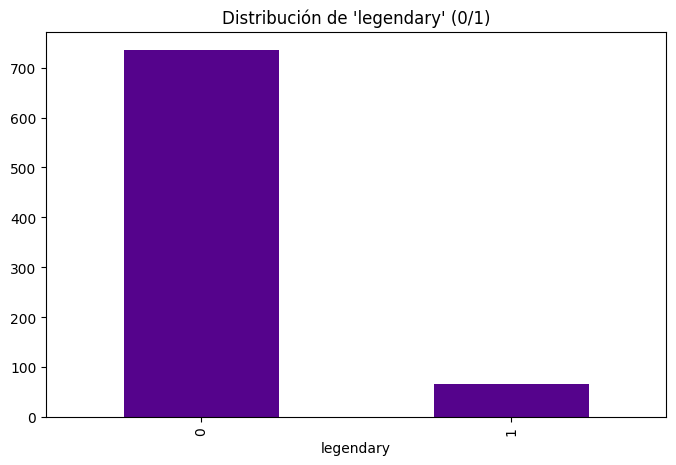

,legendary
legendary,1.000000
indice_ofensivo,0.550801
total,0.501758
power_index,0.475562
base_exp_api,0.456099
sp_atk,0.448907
peso_api,0.430683
bulk_index,0.382401
sp_def,0.363937
attack,0.345408


In [10]:
# Distribución de la variable objetivo
y.value_counts().plot(kind='bar')
plt.title("Distribución de 'legendary' (0/1)")
plt.show()

# Correlaciones numéricas principales
num_cols = X.select_dtypes(include='number').columns
corr = pd.concat([X[num_cols], y.rename('legendary')], axis=1).corr(numeric_only=True)
corr['legendary'].sort_values(ascending=False).head(15)


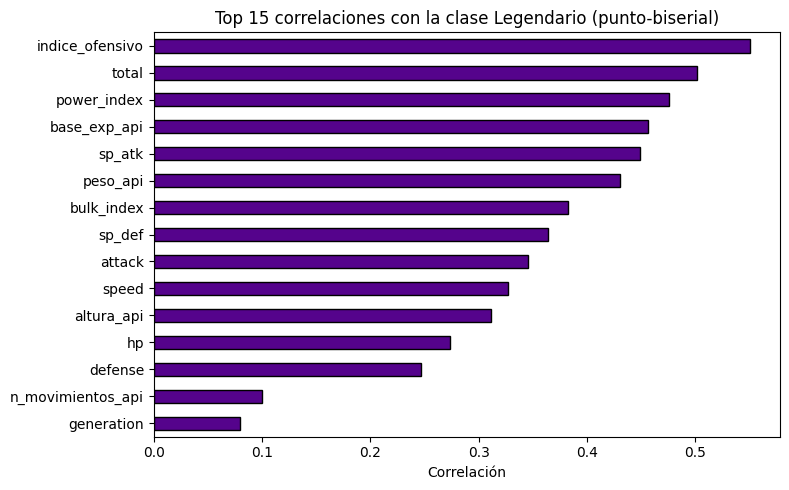

In [11]:
top = (corr['legendary']
       .drop(labels=['legendary'])
       .sort_values(ascending=False)
       .head(15))

ax = top.plot(kind='barh', color='#55038C', edgecolor='black')
plt.title("Top 15 correlaciones con la clase Legendario (punto-biserial)")
plt.xlabel("Correlación")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
redundantes = ['total','power_index','indice_ofensivo','bulk_index']
num_cols_sin_red = [c for c in num_cols if c not in redundantes]
corr_sin = pd.concat([X[num_cols_sin_red], y.rename('legendary')], axis=1)\
             .corr(numeric_only=True)['legendary']\
             .sort_values(ascending=False).head(15)
corr_sin


,legendary
legendary,1.000000
base_exp_api,0.456099
sp_atk,0.448907
peso_api,0.430683
sp_def,0.363937
attack,0.345408
speed,0.326715
altura_api,0.311902
hp,0.273620
defense,0.246377


# Borrado de Columnas

In [17]:
# Asegura que X no tenga ID/nombre/etiqueta
cols_always_drop = [c for c in ['id','name','legendary'] if c in X.columns]
X = X.drop(columns=cols_always_drop, errors='ignore')

# Preprocesamiento automático


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def make_preprocess(Xdf: pd.DataFrame) -> ColumnTransformer:
    num = Xdf.select_dtypes(include='number').columns
    cat = Xdf.select_dtypes(exclude='number').columns

    preprocess = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imp', SimpleImputer(strategy='median')),
                ('sc', StandardScaler())
            ]), num),
            ('cat', Pipeline(steps=[
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat)
        ],
        remainder='drop'
    )
    return preprocess

preprocess = make_preprocess(X)


# Entrenamiento y Validación Cruzada

In [19]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# comparación de modelos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'f1':'f1', 'ap':'average_precision', 'roc':'roc_auc'}

models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=5000),
    'RandomForest'      : RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVC'               : SVC(class_weight='balanced', probability=True, random_state=42)
}

for name, est in models.items():
    pipe = Pipeline([('pre', preprocess), ('clf', est)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{name:18s} | F1 {scores['test_f1'].mean():.3f}±{scores['test_f1'].std():.3f} "
          f"| AUC-PR {scores['test_ap'].mean():.3f} | AUC {scores['test_roc'].mean():.3f}")


LogisticRegression | F1 0.748±0.049 | AUC-PR 0.796 | AUC 0.983
RandomForest       | F1 0.660±0.165 | AUC-PR 0.812 | AUC 0.983
SVC                | F1 0.787±0.053 | AUC-PR 0.822 | AUC 0.986


In [20]:
# optimización de hiperparámetros
from sklearn.model_selection import GridSearchCV

# RandomForest
rf_pipe = Pipeline([('pre', preprocess),
                    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))])

param_grid_rf = {
    'clf__n_estimators': [300, 600, 900],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf' : [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', 0.5],
    'clf__bootstrap': [True, False],
}
grid_rf = GridSearchCV(rf_pipe, param_grid_rf,
                       scoring='average_precision', refit=True,
                       cv=cv, n_jobs=-1, verbose=1)
grid_rf.fit(X, y)
print("Mejores params RF:", grid_rf.best_params_)
print("Mejor AUC-PR RF (CV):", grid_rf.best_score_)

# SVC
svc_pipe = Pipeline([('pre', preprocess),
                     ('clf', SVC(class_weight='balanced', probability=True, random_state=42))])
param_grid_svc = {
    'clf__C': [0.5, 1, 3, 10],
    'clf__gamma': ['scale', 0.1, 0.01],
    'clf__kernel': ['rbf']
}
grid_svc = GridSearchCV(svc_pipe, param_grid_svc,
                        scoring='average_precision', refit=True,
                        cv=cv, n_jobs=-1, verbose=1)
grid_svc.fit(X, y)
print("Mejores params SVC:", grid_svc.best_params_)
print("Mejor AUC-PR SVC (CV):", grid_svc.best_score_)

# Selección del mejor por AUC-PR
best_grid = grid_rf if grid_rf.best_score_ >= grid_svc.best_score_ else grid_svc
best_name = "RandomForest" if best_grid is grid_rf else "SVC"
best_model = best_grid.best_estimator_
print(f"Mejor modelo por AUC-PR (CV): {best_name} con {best_grid.best_score_:.3f}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Mejores params RF: {'clf__bootstrap': False, 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 900}
Mejor AUC-PR RF (CV): 0.8640878163424576
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores params SVC: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Mejor AUC-PR SVC (CV): 0.8787618881343577
Mejor modelo por AUC-PR (CV): SVC con 0.879


# Entrenamiento y Evaluación

In [24]:
# entrenamiento y evaluación con partición hold-out (train/valid/test)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, roc_auc_score, confusion_matrix, classification_report

# Split estratificado
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_tr2, X_val, y_tr2, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42)
# (0.8*0.25=0.20) => 60% train, 20% val, 20% test

# Entrena en train' (X_tr2) y se elige umbral con validación
best_model.fit(X_tr2, y_tr2)
proba_val = best_model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_val)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_thr = thr[f1s[:-1].argmax()]
print(f"Umbral óptimo (max F1) en VALIDACIÓN: {best_thr:.4f}")

# Reentrenar en (train completo) y evaluar en TEST
best_model.fit(X_tr, y_tr)
proba_te = best_model.predict_proba(X_te)[:, 1]
y_pred_te = (proba_te >= best_thr).astype(int)

print("F1      :", f1_score(y_te, y_pred_te))
print("AUC-PR  :", average_precision_score(y_te, proba_te))
print("AUC-ROC :", roc_auc_score(y_te, proba_te))
print("Matriz de confusión:\n", confusion_matrix(y_te, y_pred_te))
print(classification_report(y_te, y_pred_te, zero_division=0))


Umbral óptimo (max F1) en VALIDACIÓN: 0.2563
F1      : 0.8
AUC-PR  : 0.71820855740539
AUC-ROC : 0.9811616954474096
Matriz de confusión:
 [[142   5]
 [  1  12]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       147
           1       0.71      0.92      0.80        13

    accuracy                           0.96       160
   macro avg       0.85      0.94      0.89       160
weighted avg       0.97      0.96      0.96       160



In [25]:
# Selección de variables
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.feature_selection import mutual_info_classif

# split para no mirar test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# clonar y ajustar el preprocesador solo con train
pre = best_model.named_steps['pre']
pre_tr = clone(pre).fit(X_tr, y_tr)

X_tr_tr = pre_tr.transform(X_tr)
feat_names_tr = pre_tr.get_feature_names_out()

mi = mutual_info_classif(X_tr_tr, y_tr, random_state=42)
mi_df = (pd.DataFrame({'feature': feat_names_tr, 'MI': mi})
         .sort_values('MI', ascending=False)
         .head(20))
mi_df



,feature,MI
0,num__total,0.215106
12,num__base_exp_api,0.182968
4,num__sp_atk,0.126072
15,num__power_index,0.124340
17,num__indice_ofensivo,0.117250
16,num__bulk_index,0.103334
5,num__sp_def,0.096636
9,num__peso_api,0.095050
1,num__hp,0.094781
8,num__altura_api,0.094538


In [40]:
import joblib, pandas as pd, json, time, sys, sklearn

# Guardar pipeline completo + umbral
joblib.dump(best_model, "/content/mejor_modelo_pokemon.pkl")

# Guardar evaluación de test
eval_df = pd.DataFrame({
    "y_true": y_te,
    "y_pred": (proba_te >= best_thr).astype(int),
    "y_score": proba_te
})
eval_df.to_csv("/content/evaluacion_test.csv", index=False)

# Metadatos
meta = {
    "threshold": float(best_thr),
    "metrics_test": {
        "f1": float(f1_score(y_te, (proba_te >= best_thr))),
        "auc_pr": float(average_precision_score(y_te, proba_te)),
        "auc_roc": float(roc_auc_score(y_te, proba_te))
    },
    "class_prevalence_test": float(y_te.mean()),
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "versions": {"python": sys.version.split()[0], "sklearn": sklearn.__version__}
}
with open("/content/model_metadata.json","w") as f: json.dump(meta, f, indent=2)

print("OK → mejor_modelo_pokemon.pkl, evaluacion_test.csv, model_metadata.json")


OK → mejor_modelo_pokemon.pkl, evaluacion_test.csv, model_metadata.json


# Interpretabilidad / Análisis Post-Entrenamiento

,feature,importance
6,num__speed,0.038050
7,num__generation,0.017732
9,num__peso_api,0.005300
14,num__speed_weight_ratio,0.001648
0,num__total,0.000000
1,num__hp,0.000000
5,num__sp_def,0.000000
4,num__sp_atk,0.000000
3,num__defense,0.000000
2,num__attack,0.000000


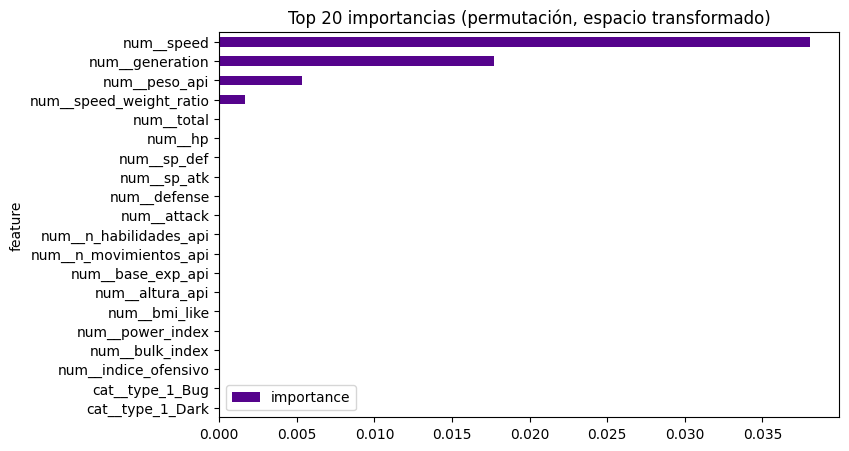

In [41]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Asegura que best_model este adecuado
pre = best_model.named_steps['pre']
clf = best_model.named_steps['clf']

# Transforma VALIDATION con el preprocesamiento ya ajustado
X_val_tr = pre.transform(X_val)
feat_names_tr = pre.get_feature_names_out()

r = permutation_importance(
    clf, X_val_tr, y_val,
    scoring='average_precision',
    n_repeats=10, random_state=42, n_jobs=-1
)

imp = (pd.DataFrame({
        "feature": feat_names_tr,
        "importance": r.importances_mean
      })
      .sort_values("importance", ascending=False)
      .head(20))

display(imp)
imp.plot(x="feature", y="importance", kind="barh")
plt.title("Top 20 importancias (permutación, espacio transformado)")
plt.gca().invert_yaxis()
plt.show()


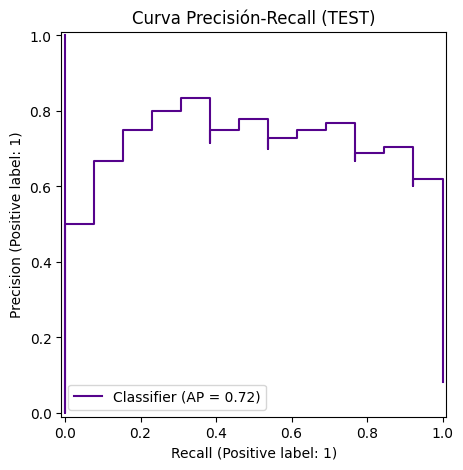

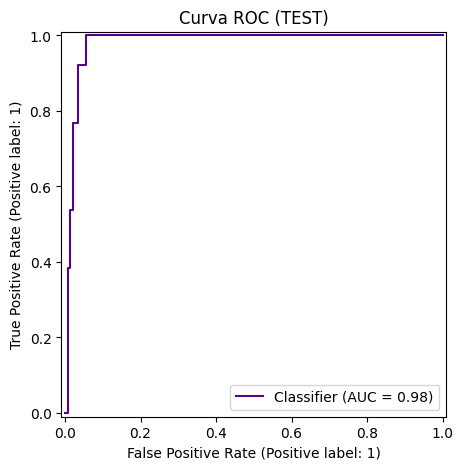

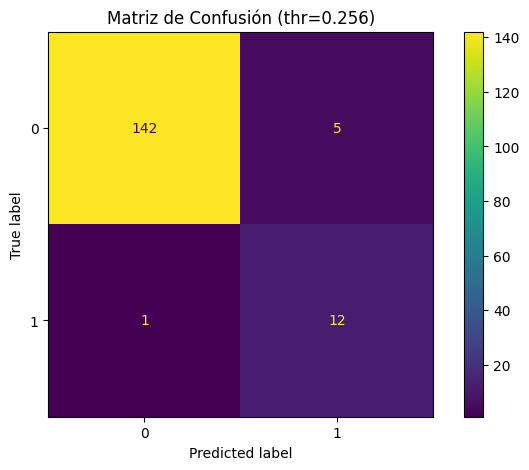

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay

# Curva Precisión-Recall (usa el umbral ya elegido)
PrecisionRecallDisplay.from_predictions(y_te, proba_te)
plt.title("Curva Precisión-Recall (TEST)")
plt.show()

# Curva ROC
RocCurveDisplay.from_predictions(y_te, proba_te)
plt.title("Curva ROC (TEST)")
plt.show()

# Matriz de confusión a umbral óptimo
ConfusionMatrixDisplay.from_predictions(y_te, y_pred_te)
plt.title(f"Matriz de Confusión (thr={best_thr:.3f})")
plt.show()


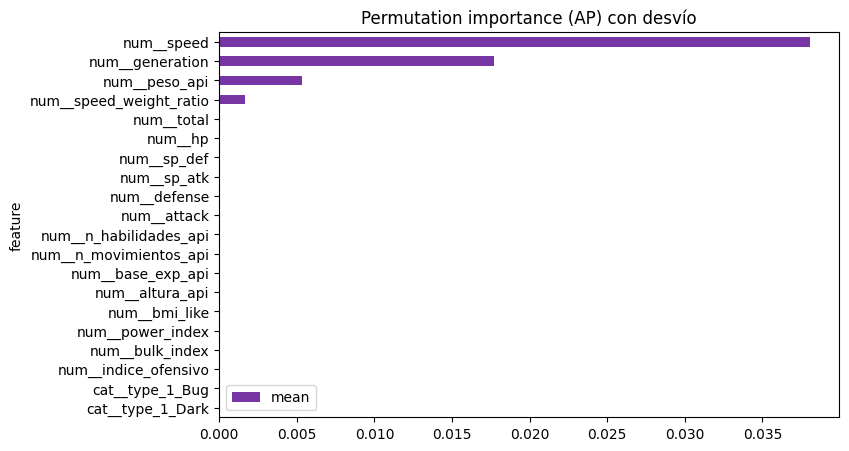

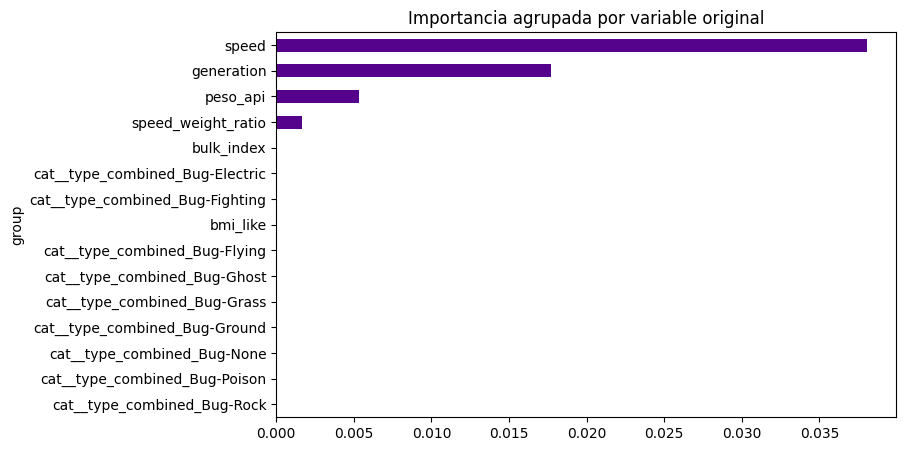

In [43]:
imp_df = pd.DataFrame({
    "feature": feat_names_tr,
    "mean": r.importances_mean,
    "std": r.importances_std
}).sort_values("mean", ascending=False)

# Top 20 con barras de error
ax = imp_df.head(20).plot(x="feature", y="mean", kind="barh", xerr=imp_df.head(20)["std"], alpha=0.8)
plt.title("Permutation importance (AP) con desvío")
plt.gca().invert_yaxis(); plt.show()

# Agrupar por variable original (suma de dummies)
def group_name(f):
    if f.startswith("cat__type_1_"): return "type_1 (todas las categorías)"
    if f.startswith("cat__type_2_"): return "type_2 (todas las categorías)"
    if f.startswith("num__"):        return f.split("__",1)[1]  # deja el nombre numérico
    return f

imp_df["group"] = imp_df["feature"].map(group_name)
grouped = imp_df.groupby("group")["mean"].sum().sort_values(ascending=False)
grouped.head(15).plot(kind="barh"); plt.title("Importancia agrupada por variable original"); plt.gca().invert_yaxis(); plt.show()


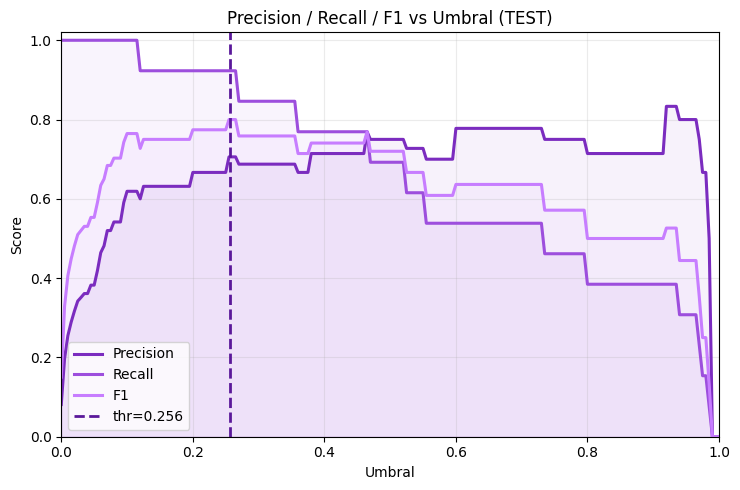

In [44]:
from sklearn.metrics import precision_score, recall_score

colors = {
    "prec": "#7b2cbf",  # violeta medio
    "rec":  "#9d4edd",  # violeta claro
    "f1":   "#c77dff",  # lila
    "thr":  "#5a189a",  # violeta oscuro
}

ts = np.linspace(0, 1, 201)
prec, rec, f1 = [], [], []
for t in ts:
    pred = (proba_te >= t).astype(int)
    prec.append(precision_score(y_te, pred, zero_division=0))
    rec.append(recall_score(y_te, pred, zero_division=0))
    f1.append(f1_score(y_te, pred, zero_division=0))

plt.figure(figsize=(7.5, 5))
plt.plot(ts, prec, label="Precision", linewidth=2.2, color=colors["prec"])
plt.plot(ts, rec,  label="Recall",    linewidth=2.2, color=colors["rec"])
plt.plot(ts, f1,   label="F1",        linewidth=2.2, color=colors["f1"])

# Línea del umbral óptimo
plt.axvline(best_thr, ls="--", linewidth=2, color=colors["thr"], label=f"thr={best_thr:.3f}")

# Opcional: un poco de relleno suave bajo las curvas
plt.fill_between(ts, prec, alpha=0.06, color=colors["prec"])
plt.fill_between(ts, rec,  alpha=0.06, color=colors["rec"])
plt.fill_between(ts, f1,   alpha=0.06, color=colors["f1"])

plt.ylim(0, 1.02)
plt.xlim(0, 1)
plt.grid(True, alpha=0.25)
plt.legend()
plt.title("Precision / Recall / F1 vs Umbral (TEST)")
plt.xlabel("Umbral")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


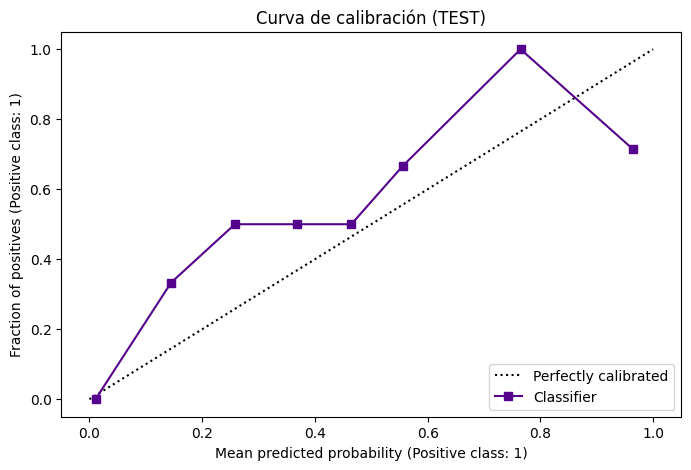

In [45]:
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_predictions(y_te, proba_te, n_bins=10)
plt.title("Curva de calibración (TEST)"); plt.show()


# Exportación del Modelo

In [46]:
# Ver el pipeline completo (pre + clf)
best_model


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  Index(['total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed',
       'generation', 'altura_api', 'peso_api', 'n_habilidades_api',
       'n_movimientos_api', 'base_exp_api', 'bmi_like', 'speed_weight_ratio',
       'power_index', 'bulk_index', 'indice_ofensivo'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['type_1', 'type_2', 'type_combined'], dtype='object'))])),
                ('clf',
                 SVC(C=10, class_weight='balanced', probability=True,
                     random_state=42))])

In [37]:
# Ver solo el clasificador y sus hiperparámetros
best_model.named_steps['clf'], best_model.named_steps['clf'].get_params()

(SVC(C=10, class_weight='balanced', probability=True, random_state=42),
 {'C': 10,
  'break_ties': False,
  'cache_size': 200,
  'class_weight': 'balanced',
  'coef0': 0.0,
  'decision_function_shape': 'ovr',
  'degree': 3,
  'gamma': 'scale',
  'kernel': 'rbf',
  'max_iter': -1,
  'probability': True,
  'random_state': 42,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False})

In [47]:
import json, sklearn, xgboost, shap, sys, platform, time

meta = {
    "threshold": float(best_thr),
    "metrics_test": {
        "f1": float(f1_score(y_te, y_pred_te)),
        "auc_pr": float(average_precision_score(y_te, proba_te)),
        "auc_roc": float(roc_auc_score(y_te, proba_te))
    },
    "class_prevalence_test": float(y_te.mean()),
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "versions": {
        "python": sys.version.split()[0],
        "sklearn": sklearn.__version__,
        "xgboost": xgboost.__version__,
        "shap": shap.__version__
    }
}
with open("/content/model_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Guardados: mejor_modelo_pokemon.pkl, evaluacion_test.csv, model_metadata.json")



Guardados: mejor_modelo_pokemon.pkl, evaluacion_test.csv, model_metadata.json


# Conclusión

El modelo es muy competente para priorizar/identificar legendarios en un contexto de clase positiva rara (~8%): combina excelente separación (AUC-ROC alta) con buen desempeño práctico en PR (AUC-PR alta). El punto operativo elegido privilegia no perder legendarios (recall 0.92) a cambio de pocos falsos positivos (5), adecuado cuando el costo de omitir un legendario supera al de revisar candidatos extra. Alcance y limitaciones: (i) los resultados reflejan este dataset y su prevalencia; con otras generaciones/definiciones de “legendario” el rendimiento puede variar; (ii) la señal de generation indica sesgo de distribución, lo que reduce la generalización fuera del dominio; (iii) varias features derivadas muestran baja importancia por redundancia/colinealidad con stats base; (iv) las probabilidades del SVC (Support Vector Classifier) pueden requerir calibración si se usarán para decisiones finas dependientes del umbral; (v) si cambian los costos de falsos positivos/negativos, conviene reajustar el umbral (o explorar puntos con mayor precision y menor recall). En síntesis, el sistema es una base sólida para decidir con énfasis en cobertura de legendarios, con margen de ajuste si el objetivo pasa a reducir falsos positivos.